# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Claire Meyer, Nicolas Furrer, Philipp Schuler
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

# End of cell
print("Done")

Done


## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

Done


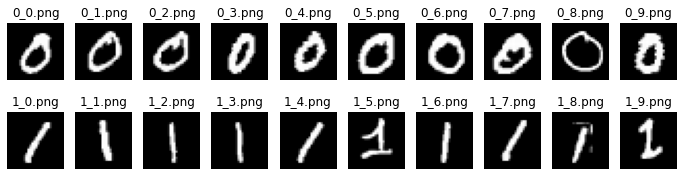

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2 as cv
import math

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

# Load zeros
path_0 = os.path.join(data_base_path, data_folder, 'part1', '0')
names_0 = [nm for nm in os.listdir(path_0) if '.png' in nm]  # make sure to only load .png
names_0.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(path_0, nm) for nm in names_0])
imgs_0 = skimage.io.concatenate_images(ic)

# Load ones
path_1 = os.path.join(data_base_path, data_folder, 'part1', '1')
names_1 = [nm for nm in os.listdir(path_1) if '.png' in nm]  # make sure to only load .png
names_1.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(path_1, nm) for nm in names_1]))
imgs_1 = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(imgs_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], imgs_0, names_0):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], imgs_1, names_1):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# End of cell
print("Done")

### 1.2 Fourier descriptors
Here is an implementation of the Fouriers Descriptors (FD) :

* The `Z, Nin, m, phi, numrows, numcols = fd(img, N=contour length, method="cropped")` function computes the FDs from an image and returns the complex FFT, the number of number in the original contour (for consistency of the signal power), the modulus and the phase of the FFT, the number of rows and columns in the image.
* The `img = ifd(Z, Nin, numrows, numcols, Nout = Z length)` function computes the IFDs (Inverse Fourier Descriptors), from the arguments returned by the previous function. 
* The `m = afd(img, N=contour length, method="cropped")`function computes AFDs (Adjusted Fourier Descriptors) from an image. Those are invariant by translation, rotation and scaling. If the FDs are :
$$ \texttt{FD} = r_{-n}e^{i\theta_{-n}} \dots r_{-1}e^{i\theta_{-1}}, r_0e{i\theta_0}, r_1e^{i\theta_1} \dots r_ne^{i\theta_n}$$

$$ = \texttt{FD}_{-n} \dots \texttt{FD}_{-1}, \texttt{FD}_{0}, \texttt{FD}_{1} \dots \texttt{FD}_{n}$$

Then the IFDs are :

$$ \texttt{AFD} = \dfrac{\texttt{FD}_{-n}}{\texttt{FD}_{1}} \dots \dfrac{\texttt{FD}_{-2}}{\texttt{FD}_{1}}, \dfrac{\texttt{FD}_{2}}{\texttt{FD}_{1}} \dots \dfrac{\texttt{FD}_{n}}{\texttt{FD}_{1}}$$

Because :
* the coefficient 0 gives information on the location $(x,y)$ within the image (translation), so we remove it altogether,
* the coefficient 1 (and its hermitian symetric -1) gives information on the average size (scaling), so we divide the signal by that coefficient and remove it from the signal,
* the phase gives information on the rotation, so we only keep the modulus.

Now the AFDs are invariant by translation, rotation and scaling. Below is our implementation of it, with an image reconstructed from its FDs for proof of concept :

Done


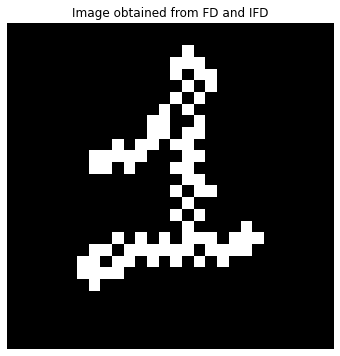

In [3]:
# fd computes the Fourier Descriptors of a shape. 
#     Z, Nin, m, phi, numrows, numcols = fd(img, N=contour length, method="cropped")
def fd(img, N=None, method="cropped"):
    # Converting from RGB to grayscale if necessary
    if len(img.shape)==3:
        img	= cv.cvtColor(src=img, code=cv.COLOR_RGB2GRAY)
        
    # Converting to binary image
    _, img = cv.threshold(src=img, thresh=0, maxval=1, type=(cv.THRESH_BINARY | cv.THRESH_OTSU))
    [numrows, numcols]=img.shape
    
    # Extracting the contours
    contours,_ = cv.findContours(image=img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    contours = np.asarray(contours).squeeze()
    
    if len(contours.shape)==1:
        i = np.argmax([len(c) for c in contours])
        contours = (contours[i][:,:]).squeeze()
    
    # Complex periodic signal out of the contours
    y = contours[:,0]
    x = contours[:,1]
    z = x + y*1j;
    Nin = z.size;
    
    # Assigning default arg
    if N is None:
        N = Nin;

    # Processing to get the fft
    Z = np.fft.fft(z);

    # Magic to get the correct signal length
    if Nin < N:
        dst = img.copy()
        cv.resize(img, dst, fx=2, fy=2, interpolation=cv.INTER_LINEAR)
        Z, Nin, _, _, _, _ = fd(dst, N, method)
    elif Nin > N:
        i = math.ceil(N/2)

        if method=="cropped":
            Z=np.concatenate((Z[:i],Z[-i:]))
        elif method=="padded":
            Z[i:-i]=0
        else:
            raise ValueError(f"Incorrect 'method' : {method}.")

    m = np.absolute(Z)
    phi = np.angle(Z)
    
    return Z, Nin, m, phi, numrows, numcols
    
    
# IFD computes the inverse Fourier Descriptors of a complex signal. 
#     img = ifd(Z, Nin, numrows, numcols, Nout = Z length)
def ifd(Z, Nin, numrows, numcols, Nout=None):

    # Initialization
    N = Z.size

    # Assigning default arg
    if Nout is None:
        Nout = N
    
    # Magic to get the correct signal length
    if N != Nout:        
        if N < Nout:
            i = math.ceil(N/2)
            Z = np.concatenate((Z[:i],np.zeros(Nout-N),Z[i:]))
        elif N > Nout:
            i = math.ceil(Nout/2)
            Z = np.concatenate((Z[:i],Z[-i:]))

    # Processing
    z = np.fft.ifft(Z)
    z = z*Nout/Nin 
    x = z.real
    y = z.imag
    row = y.astype(np.uint8)
    col = x.astype(np.uint8)
    
    img = np.zeros((numrows, numcols), np.uint8)
    
    for xi,yi in zip(col, row):
        if (xi>=0 & yi>=0 & xi<numcols & yi<numrows):
            img[xi,yi] = 255
    
    return img

# AFD computes the adjusted Fourier Descriptors (invariant by translation, rotation, and scaling).
#     m = afd(img)
def afd(img, N=None, method="cropped"):
    Z, _, _, _, _, _ = fd(img, N, method)
    Z = Z/Z[1]
    Z = Z[2:-1]
    m = np.absolute(Z)
    return m

# Computes Fourier Descriptos and Inverse Fourier Descriptors for proof of concept
Z, Nin, m, phi, numrows, numcols = fd(img=imgs_1[5])
img_out = ifd(Z, Nin, numrows, numcols, Nout=400)

# Plot
n_lin = 1
n_col = 1
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
ax.imshow(img_out, cmap="gray")
ax.set_title("Image obtained from FD and IFD")
ax.axis("off")

# End of cell
print("Done")

### 1.3 Number of peaks on $x$ and $y$ projections
The main idea of this method is to do an horizontal and vertical projection of the image containing the character, which produces to vectors of dimensions $h$ and $w$ respectively; considering that $h$ is the height of the image in pixels, and $w$ its width (in pixels). Then, on each of these vectors, we count the number of values exceeding a set threshold (the number of peaks on the $x$ and $y$ projections).

This method can sort the ones fromt the zeroes, as the number 1 is very thin, and very vertical, whereas the number 0 is stocky. To do this, we apply the following steps :
- Apply a treshold and a morphologic opening if needed, like for the image 1_8, to transform the image in a clean, binary image
- Make the sum of the pixels in each row and each colum
- Treshold those vectors and count the occurences to have the number of rows/colums which exceed the threshold
- Take those two values as features for the image

With this method, we have an issue with the number 1. Indeed, as we can see in the aboves images, the ones are not always vertical. To solve this issue, we detect the character, its position and orientation, so as to center and rotate it to align the axis. The steps change to become : 
- Apply a treshold and a morphologic opening if needed, like for the image 1_8, to transform the image in a clean, binary image
- Detect the rotated bouding box which fits the character 
- Translate the character to the center of the image
- Rotate the character to align its borders vertically
- Make the sum of the pixels in each row and each colum
- Treshold those vectors and count the occurences to have the number of rows/colums which exceed the threshold
- Take those two values as features for the image

Below is our implementation of it, along with the transformation that makes the characters centered and aligned (for illustration purposes) :

Done


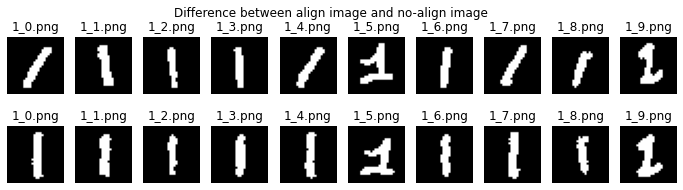

In [4]:
# Apply  a treshold and a opening if needed
# Parameter : List of images, and list of boolean, True : opening applied, False : nothing
# Return : List of images
def applyMorphology(list_img, morpho):
    kernel = np.zeros((3,3), np.uint8)
    cv.circle(img=kernel, center=(1,1), radius=1, color=255, thickness=-1)
    result = list_img.copy()
    for im, i, morph in zip(list_img, range(list_img.size), morpho):
        im_t = cv.inRange(im, 10,255)
        im_t = im_t/255
        copy_im = im_t.copy()
        if morph:
            result[i] = cv.morphologyEx(copy_im, cv.MORPH_OPEN, kernel, iterations=1)
        else:
            result[i] = im_t.copy()
        
    return result

# Counts number of peak per axis with a value minimal of peak_value
# Parameter : list of images, value minimal of the peak
# Return : number of peak > peak_value of x and y
def countPeakOnAxes(list_img, peak_value):
    
    peak_in_x = np.zeros(10)
    peak_in_y = np.zeros(10)
    for im, i in zip(list_img, range(list_img.size)):

        for x in range(im[0,:].size):
            if sum(im[x,:]) > peak_value:
                peak_in_x[i] = peak_in_x[i] + 1

        for y in range(im[:,0].size):
            if sum(im[:,y]) > peak_value:
                peak_in_y[i] = peak_in_y[i] + 1
                
    return peak_in_x, peak_in_y

# Plots number corresponding to each point
# Parameter : list of value in x, list of value in y
def plotNumber(nb_peak_x,nb_peak_y):
    for x,y,i in zip(nb_peak_x, nb_peak_y, range(nb_peak_x.size)):
        plt.text(x,y, str(i), color="black", fontsize=15)
        
        
        
# Transform the image in a list of image to have the number center and align
# Parameter : List of image
# Return : List of image with number center and align
def transform(list_img):
    result = np.zeros(list_img.shape)
    for img, nb in zip(list_img, range(list_img.size)):
        rows,cols = img.shape
        # Find the contours of the image
        _, threshholded_img = cv.threshold(src=img, thresh=0, maxval=255, type=(cv.THRESH_BINARY | cv.THRESH_OTSU))
        contour, _ = cv.findContours(image=threshholded_img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)        
        drawing = img.copy()
        # Find the rectangle who fit the bigger contour
        minRect = cv.minAreaRect(contour[0])
        (x, y), (width, height), angle = minRect
        # Translate the image to have the center of the rectangle in the center of the image
        M1 = np.float32([[1,0,list_img.shape[1]/2-x],[0,1,list_img.shape[2]/2-y]])
        dst1 = cv.warpAffine(drawing,M1,(cols,rows))
        # Rotate the image to have the rectangle align with the axis
        if(angle<-45):
            angle = angle +90
        elif(angle>45):
            angle = angle -90
        M2 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
        result[nb] = cv.warpAffine(dst1,M2,(cols,rows))
    return result

# Plot
morph_1 = [False,False,False,False,False,False,False,False,True,False]
imgs_1_m = applyMorphology(imgs_1,morph_1)
imgs_1_mt = transform(imgs_1_m)
fig, axes = plt.subplots(2, len(imgs_1), figsize=(12, 3))
fig.suptitle("Difference between align image and no-align image")
for ax, im, nm in zip(axes[0], imgs_1_m, names_1):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], imgs_1_mt, names_1):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# End of cell
print("Done")

### 1.4 Oriented bounding box ratio and number of closed loops
The next two additional features are the ratio of the character's oriented bounding box, as well as the number of closed loops present in that character. 

The functions below extract these features and returns different informations :
 - the two features we want
 - the image of the bounding box superimposed on the character for illustration purposes
 - the number of closed loops

The rectangle ratio calculation is done by :
 - Taking the original img and finding the external contour after binarizing it,
 - Finding the oriented bounding box around that contour,
 - Calculating the width/height ratio of that oriented bounding box. 
 
The number of closed loops are found by :
 - Thresholding the image to obtain an inverted binary image,
 - With the `connectedComponentsWithStats()` function, finding the number of labels,
 - As the background, and the drawing each count for a label, subtracting 2 from the returned number of labels, thus getting the number of closed loops.
 
Below is our implementation of it :

Done


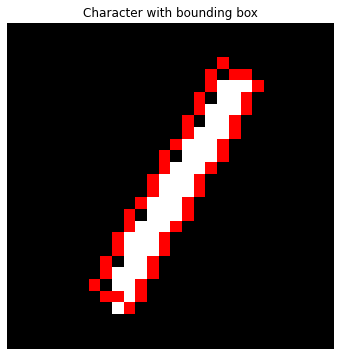

In [5]:
# Computes the ratio of the rotated bounding box. 
def getRatio(img):
    _, threshholded_img = cv.threshold(src=img, thresh=0, maxval=255, type=(cv.THRESH_BINARY | cv.THRESH_OTSU))
    
    superimposed_img = threshholded_img.copy()
    superimposed_img = cv.cvtColor(src=superimposed_img, code=cv.COLOR_GRAY2RGB)
    
    contour, _ = cv.findContours(image=threshholded_img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
    
    minRect = cv.minAreaRect(contour[0])
    (x, y), (width, height), angle = minRect
    
    box = cv.boxPoints(minRect)
    cv.drawContours(superimposed_img, [np.intp(box)], 0, [255,0,0])

    if width >= height:
        ratio = width/height
    else:
        ratio = height/width
    
    return ratio, superimposed_img


# Computes the number of closed loops in the image
def getClosedLoops(img):
    # number of centroids, this gives the number of closed loops + 2 (background + first color)
    _, threshholded_img = cv.threshold(src=img, thresh=0, maxval=1, type=(cv.THRESH_BINARY_INV | cv.THRESH_OTSU))
    label_number, _, _, _ = cv.connectedComponentsWithStats(image=threshholded_img,connectivity=4)
    
    # label number minus 2 for image and background
    closed_loops = label_number-2
    
    return closed_loops

# Computes bounding box of char in img
_, superimposed_img  =  getRatio(imgs_1[4])

# Plot
n_lin = 1
n_col = 1
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
ax.imshow(superimposed_img, cmap="gray")
ax.set_title("Character with bounding box")
ax.axis("off")

# End of cell
print("Done")

### 1.5 Features extractions and plots

Here is the code that extracts all the features and plot them on 2D plots :


Done


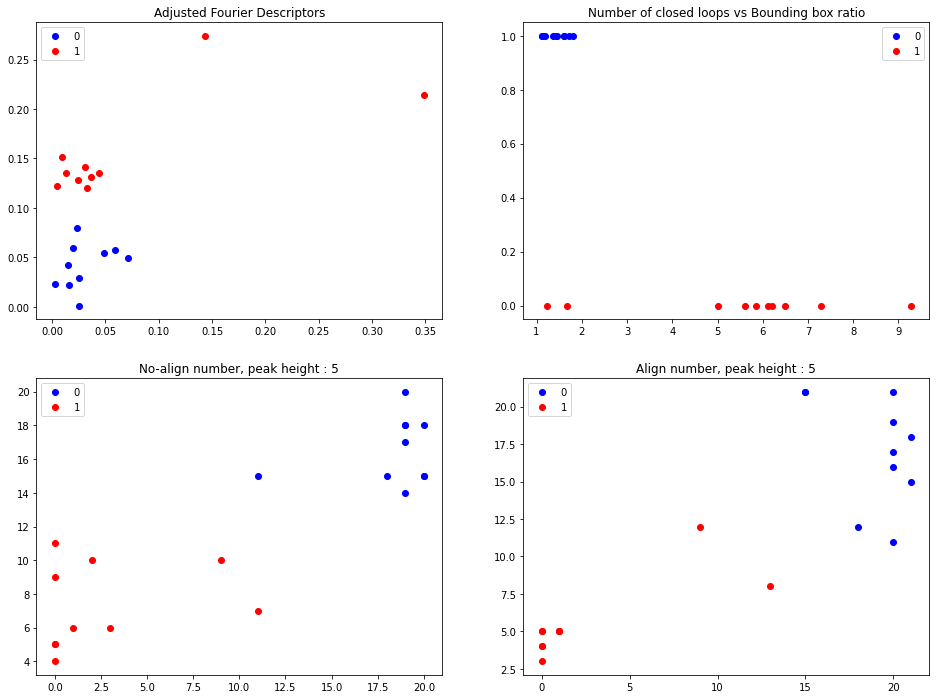

In [6]:
# Applying basic morphological operation to clean imgs
morph_0 = [False,False,False,False,False,False,False,False,False,False]
morph_1 = [False,False,False,False,False,False,False,False,True,False]

imgs_m_0 = applyMorphology(imgs_0, morph_0)
imgs_m_1 = applyMorphology(imgs_1, morph_1)

# Applying transformation
mt_0 = transform(imgs_m_0)
mt_1 = transform(imgs_m_1)

# Features arrays
peak_tresholds = np.array([5,5])
nb_peak_x = np.zeros((2,10))
nb_peak_y = np.zeros((2,10))
nb_peak_xmt = np.zeros((2,10))
nb_peak_ymt = np.zeros((2,10))
modules = np.zeros((2,2,10))
closed_loops = np.zeros((2,10))
ratio = np.zeros((2,10))

# Computing all the features
for j in range(10):
    # number of peaks
    nb_peak_x[0,:], nb_peak_y[0,:] = countPeakOnAxes(imgs_m_0,peak_tresholds[0])
    nb_peak_x[1,:], nb_peak_y[1,:] = countPeakOnAxes(imgs_m_1,peak_tresholds[0])
    nb_peak_xmt[0,:], nb_peak_ymt[0,:] = countPeakOnAxes(mt_0,peak_tresholds[1])
    nb_peak_xmt[1,:], nb_peak_ymt[1,:] = countPeakOnAxes(mt_1,peak_tresholds[1])
        
    # modules
    m = afd(imgs_m_0[j])
    modules[0,:,j] = m[0:2]
    m = afd(imgs_m_1[j])
    modules[1,:,j] = m[0:2]
    
    # closed loops
    closed_loops[0,j] = getClosedLoops(imgs_0[j])
    closed_loops[1,j] = getClosedLoops(imgs_1[j])
    
    # ratio
    ratio[0,j], _ = getRatio(imgs_0[j])
    ratio[1,j], _ = getRatio(imgs_1[j])

# Plots
n_lin = 2
n_col = 2
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(size*0.4/0.3*n_col, size*n_lin))

ax[0,0].plot(modules[0,0,:], modules[0,1,:], "bo", label="0")
ax[0,0].plot(modules[1,0,:], modules[1,1,:], "ro", label="1")
ax[0,0].legend(loc="upper left")
ax[0,0].set_title(f"Adjusted Fourier Descriptors")

ax[0,1].plot(ratio[0,:], closed_loops[0,:], "bo", label="0")
ax[0,1].plot(ratio[1,:], closed_loops[1,:], "ro", label="1")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title(f"Number of closed loops vs Bounding box ratio")

ax[1,0].plot(nb_peak_x[0,:], nb_peak_y[0,:], "bo", label="0")
ax[1,0].plot(nb_peak_x[1,:], nb_peak_y[1,:], "ro", label="1")
ax[1,0].legend(loc='upper left')
ax[1,0].set_title(f"No-align number, peak height : {peak_tresholds[0]}")

ax[1,1].plot(nb_peak_xmt[0,:], nb_peak_ymt[0,:], "bo", label="0")
ax[1,1].plot(nb_peak_xmt[1,:], nb_peak_ymt[1,:], "ro", label="1")
ax[1,1].legend(loc='upper left')
ax[1,1].set_title(f"Align number, peak height : {peak_tresholds[1]}")

# End of cell
print("Done")

### 1.6 Disscussion
We can see on the above plots that we can sort linearly the number 0 from the number 1 with the features implemented. 

On the first plot, the first two coefficients from the AFDs (Adjusted Fourier Descriptors) are plotted. The AFDs are an invariant by translation, rotation and scaling version of the FDs (the Fourier Descriptors). The zeroes are nicely clustered, but since there are two variants for the the ones, we can see two outliers for this class. The ones and zeroes are nonetheless seperable. The FDs were not even used, because they are sensible to translation, rotation, and scaling, so not robust at all.

On the second graph, we have the number of closed loops and the oriented bounding box ratio. We can see that the number of closed loops separates perfectly the numbers 0 and 1. The number 0 has one closed loop and the number 1 has zero closed loops. The oriented bounding box ratio is useless feature with the number of closed loops for distinguishing the zeroes from the ones, because here the seperation is very clear from the first feature already. Nonetheless, with other classes, or very badly written characters, it could perhaps gain in usefulness.

On the third and fourth plots, we have the number of peaks on each projections ($x$ and $y$). In the first one, the number 1 has more peaks on the horizontal projection than on the vertical one (the threshold for the peaks is 5). The number 0 has is more rounded, so it has a similar number of peaks on each projections. It is the expected result, as the number 0 can be seen as a circle and the number 1 as a vertical line. 

On the fourth plot, we have the same results, but we are now more robust to the (slight) rotation, which make the number 1 less spread in the graph.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

Done


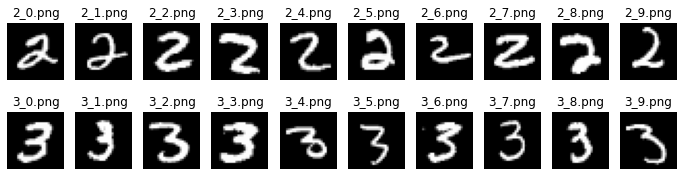

In [7]:
# Load twos
path_2 = os.path.join(data_base_path, data_folder, 'part2', '2')
names_2 = [nm for nm in os.listdir(path_2) if '.png' in nm]  # make sure to only load .png
names_2.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(path_2, nm) for nm in names_2])
imgs_2 = skimage.io.concatenate_images(ic)

# Load threes
path_3 = os.path.join(data_base_path, data_folder, 'part2', '3')
names_3 = [nm for nm in os.listdir(path_3) if '.png' in nm]  # make sure to only load .png
names_3.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(path_3, nm) for nm in names_3]))
imgs_3 = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(imgs_2), figsize=(12, 3))
for ax, im, nm in zip(axes[0], imgs_2, names_2):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], imgs_3, names_3):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# End of cell
print("Done")

### 2.2 Features extractions and plots

Here is the code that extracts all the features and plot them on 2D plots :

Done


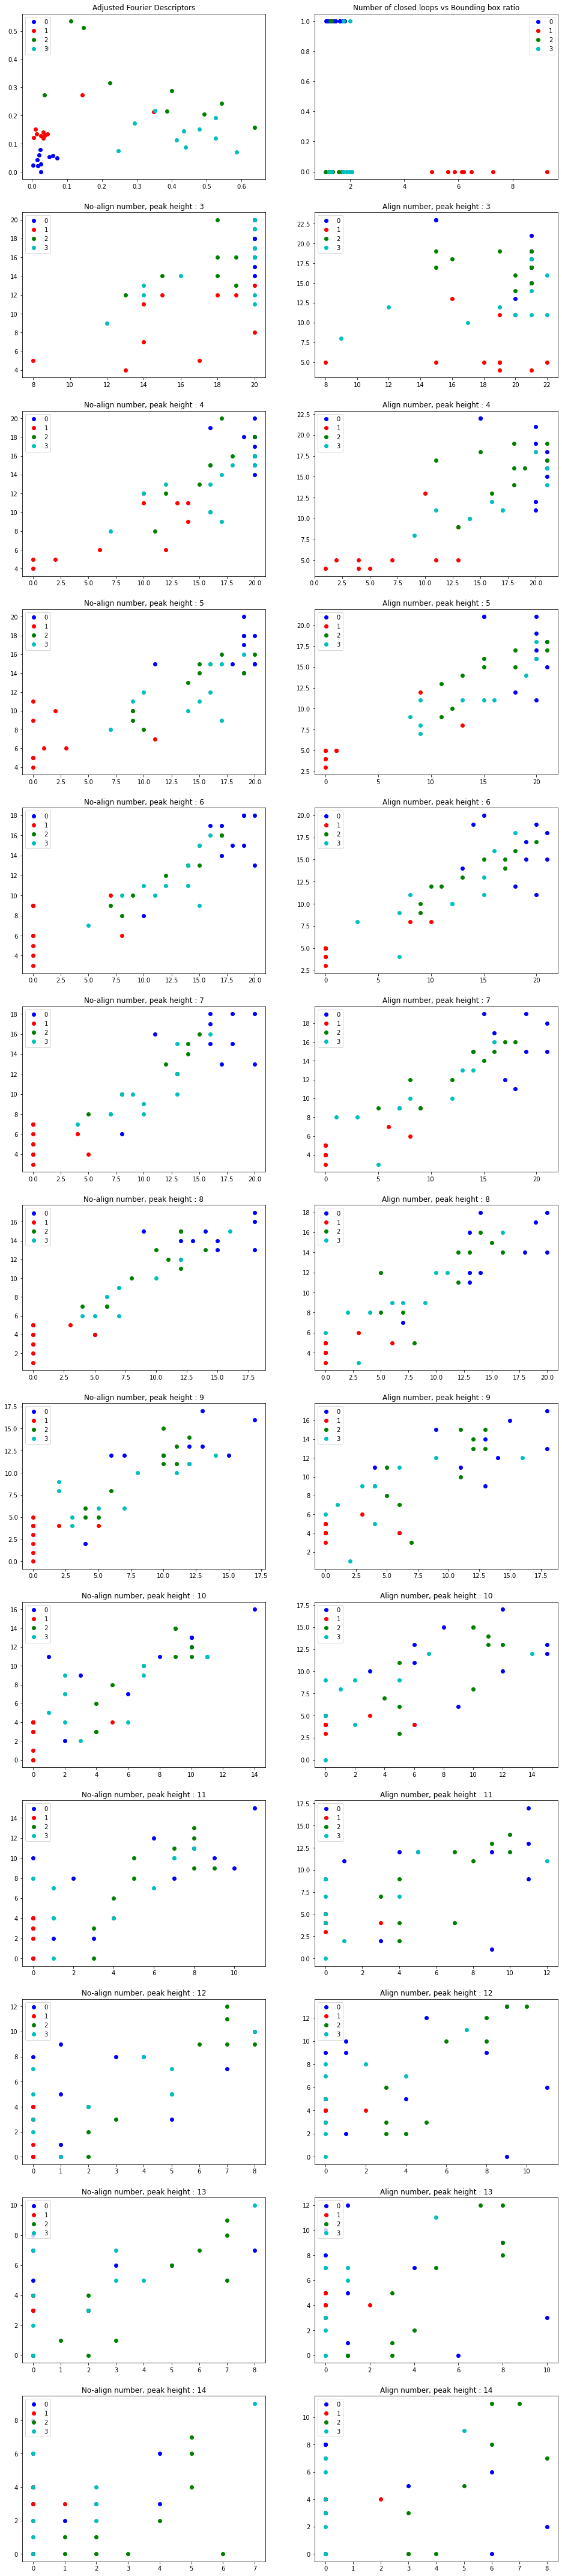

In [8]:
# Applying basic morphological operation to clean imgs
morph_0 = [False,False,False,False,False,False,False,False,False,False]
morph_1 = [False,False,False,False,False,False,False,False,True,False]
morph_2 = [False,False,False,False,False,False,False,False,False,False]
morph_3 = [False,False,False,False,False,False,False,False,False,False]

imgs_m_0 = applyMorphology(imgs_0, morph_0)
imgs_m_1 = applyMorphology(imgs_1, morph_1)
imgs_m_2 = applyMorphology(imgs_2, morph_2)
imgs_m_3 = applyMorphology(imgs_3, morph_3)

# Applying transformation
mt_0 = transform(imgs_m_0)
mt_1 = transform(imgs_m_1)
mt_2 = transform(imgs_m_2)
mt_3 = transform(imgs_m_3)

# Features arrays
peak_tresholds = np.arange(3,15)
nb_peak_x = np.zeros((4,12,10))
nb_peak_y = np.zeros((4,12,10))
nb_peak_xmt = np.zeros((4,12,10))
nb_peak_ymt = np.zeros((4,12,10))
modules = np.zeros((4,2,10))
closed_loops = np.zeros((4,10))
ratio = np.zeros((4,10))

# Computing all the features
for j in range(10):
    for i in range(12):
        # number of peaks
        nb_peak_x[0,i,:], nb_peak_y[0,i,:] = countPeakOnAxes(imgs_m_0,peak_tresholds[i])
        nb_peak_x[1,i,:], nb_peak_y[1,i,:] = countPeakOnAxes(imgs_m_1,peak_tresholds[i])
        nb_peak_x[2,i,:], nb_peak_y[2,i,:] = countPeakOnAxes(imgs_m_2,peak_tresholds[i])
        nb_peak_x[3,i,:], nb_peak_y[3,i,:] = countPeakOnAxes(imgs_m_3,peak_tresholds[i])
        nb_peak_xmt[0,i,:], nb_peak_ymt[0,i,:] = countPeakOnAxes(mt_0,peak_tresholds[i])
        nb_peak_xmt[1,i,:], nb_peak_ymt[1,i,:] = countPeakOnAxes(mt_1,peak_tresholds[i])
        nb_peak_xmt[2,i,:], nb_peak_ymt[2,i,:] = countPeakOnAxes(mt_2,peak_tresholds[i])
        nb_peak_xmt[3,i,:], nb_peak_ymt[3,i,:] = countPeakOnAxes(mt_3,peak_tresholds[i])
        
    # modules
    m = afd(imgs_m_0[j])
    modules[0,:,j] = m[0:2]
    m = afd(imgs_m_1[j])
    modules[1,:,j] = m[0:2]
    m = afd(imgs_m_2[j])
    modules[2,:,j] = m[0:2]
    m = afd(imgs_m_3[j])
    modules[3,:,j] = m[0:2]
    
    # closed loops
    closed_loops[0,j] = getClosedLoops(imgs_0[j])
    closed_loops[1,j] = getClosedLoops(imgs_1[j])
    closed_loops[2,j] = getClosedLoops(imgs_2[j])
    closed_loops[3,j] = getClosedLoops(imgs_3[j])
    
    # ratio
    ratio[0,j], _ = getRatio(imgs_0[j])
    ratio[1,j], _ = getRatio(imgs_1[j])
    ratio[2,j], _ = getRatio(imgs_2[j])
    ratio[3,j], _ = getRatio(imgs_3[j])

# Plots
n_lin = 13
n_col = 2
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(size*0.4/0.3*n_col, size*n_lin))

ax[0,0].plot(modules[0,0,:], modules[0,1,:], "bo", label="0")
ax[0,0].plot(modules[1,0,:], modules[1,1,:], "ro", label="1")
ax[0,0].plot(modules[2,0,:], modules[2,1,:], "go", label="2")
ax[0,0].plot(modules[3,0,:], modules[3,1,:], "co", label="3")
ax[0,0].legend(loc="upper left")
ax[0,0].set_title(f"Adjusted Fourier Descriptors")

ax[0,1].plot(ratio[0,:], closed_loops[0,:], "bo", label="0")
ax[0,1].plot(ratio[1,:], closed_loops[1,:], "ro", label="1")
ax[0,1].plot(ratio[2,:], closed_loops[2,:], "go", label="2")
ax[0,1].plot(ratio[3,:], closed_loops[3,:], "co", label="3")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title(f"Number of closed loops vs Bounding box ratio")

for i in range(peak_tresholds.size):
    ax[i+1,0].plot(nb_peak_x[0,i,:], nb_peak_y[0,i,:], "bo", label="0")
    ax[i+1,0].plot(nb_peak_x[1,i,:], nb_peak_y[1,i,:], "ro", label="1")
    ax[i+1,0].plot(nb_peak_x[2,i,:], nb_peak_y[2,i,:], "go", label="2")
    ax[i+1,0].plot(nb_peak_x[3,i,:], nb_peak_y[3,i,:], "co", label="3")
    ax[i+1,0].legend(loc='upper left')
    ax[i+1,0].set_title(f"No-align number, peak height : {peak_tresholds[i]}")

    ax[1+i,1].plot(nb_peak_xmt[0,i,:], nb_peak_ymt[0,i,:], "bo", label="0")
    ax[1+i,1].plot(nb_peak_xmt[1,i,:], nb_peak_ymt[1,i,:], "ro", label="1")
    ax[1+i,1].plot(nb_peak_xmt[2,i,:], nb_peak_ymt[2,i,:], "go", label="2")
    ax[1+i,1].plot(nb_peak_xmt[3,i,:], nb_peak_ymt[3,i,:], "co", label="3")
    ax[1+i,1].legend(loc='upper left')
    ax[1+i,1].set_title(f"Align number, peak height : {peak_tresholds[i]}")

# End of cell
print("Done")

### 2.3 Conclusion

Globally, classifying the four classes (the zeroes, ones, twos and threes) from fimple features paired two by two like we did does not work. 

The Adjusted Fourier Descriptors were the most robust features. From the look of the graph, with a knn classifier, it *looks* like it could classify the classes from those points with a high percentage of success (more than 85% from the look of it). __BUT__ to actually validate that hypothesis, it would require to have a much bigger training sample, and also a testig sample.

The number of closed loops as a feature drops dramatically in relevance when the twos and threes appear, because those two classes both present 0 and 1 closed loops depending on how they are written (style and hurriedness). A three, whatever the style, should always have zero closed loops, but one of the threes is so badly written it actually has a closed loop. The twos will vary depending on the style. Unfortunately, the ratio of the oriented bounding box doesn't help to discriminate with the diminution in separation from the closed loops feature. That's because the twos and threes tend to have very varied oriented bounding boxes (when we look at them). The ones can mostly be separated from the three other classes, but not even well.

Then, the number of peaks in the $x$ and $y$ projection becomes just generally confusing when classes are added. We computed for 12 different values of threshold to apply to the projection vectors, and both with centered and aligned character and without. But as can be seen on the 24 last plots, it really doesn't help separate the classes.

What would be interesting, would be to compute a 30 or so dimensional feature vector, with a lot number of peaks from the projections for different values, the number of closed loops, the oriented bounding box ratio and maybe the first four AFDs coefficients, and then run a PCA on it, to see if something comes out. Or just apply the AlexNet CNN on the characters, but that would bypass the educational goals of that lab.